In [27]:
from LogReg_TS import *
from LinTS import *
from Bernoulli_TS import *
from LInUCB import *
from EpsilonGreedy import *
from tqdm import tqdm
from utils import get_data, compute_regret
import matplotlib.pyplot as plt
import pandas as pd
import pickle
plt.rcParams["figure.figsize"] = (16,9)
plt.rcParams.update({'font.size': 18})

### Read Data

In [37]:
streaming_batch, user_feature, reward_list, action_context = get_data()
action_context = np.array(action_context.iloc[:,2:])

K, D = action_context.shape
T = len(streaming_batch)
#T = 15000
starting_point = 5000

### Random

In [38]:
seq_error = np.full(T-1-starting_point,0)
for t in tqdm(range(0, T-1-starting_point)):
    feature_user = np.array(user_feature[user_feature.index == int(streaming_batch.iloc[t+starting_point+1, 0])])
    watched_list = reward_list[reward_list['user_id'] == int(streaming_batch.iloc[t+starting_point+1, 0])]
    
    optimal_action = np.random.randint(K)

    if optimal_action in list(watched_list['movie_id']):
        reward = 1.0
        regret = 0.0
    else:
        reward = 0.0
        regret = 1.0

    if t == 0:
            seq_error[t] = regret
    else:
            seq_error[t] = seq_error[t-1] + regret
            
cum_reg_random = compute_regret(seq_error)
seq_err_random = seq_error
print(cum_reg_random[-1] * 100)

100%|██████████| 23016/23016 [01:38<00:00, 233.19it/s]

36.865658672228015


### Bernoulli

In [39]:
# Parameters
alpha = 1
beta = 1

# Init bandit
bandit = Bernoulli_TS(alpha=alpha, beta=beta, K=K)

# 
seq_error = np.full(T-1-starting_point,0)
for t in tqdm(range(0, T-1-starting_point)):
    feature_user = np.array(user_feature[user_feature.index == int(streaming_batch.iloc[t+1+starting_point, 0])])
    watched_list = reward_list[reward_list['user_id'] == int(streaming_batch.iloc[t+1+starting_point, 0])]
    
    optimal_action = bandit.get_action()
    
    if optimal_action in list(watched_list['movie_id']):
        reward = 1.0
        regret = 0.0
    else:
        reward = 0.0
        regret = 1.0

    if t == 0:
            seq_error[t] = regret
    else:
            seq_error[t] = seq_error[t-1] + regret

    bandit.update(reward, optimal_action)

cum_reg_bernoulli = compute_regret(seq_error)
seq_err_bernoulli = seq_error
print(cum_reg_bernoulli[-1] * 100)

100%|██████████| 23016/23016 [02:29<00:00, 153.87it/s]

23.105665623913797


### Linear UCB

In [40]:
# Parameters
alpha = 1
lambda_ = 1

# Init bandit
bandit = LinUCB(alpha, D, T, K, lambda_, disjoint=False)

# 
seq_error = np.full(T-1-starting_point,0)
for t in tqdm(range(0, T-1-starting_point)):
    feature_user = np.array(user_feature[user_feature.index == int(streaming_batch.iloc[t+1+starting_point, 0])])
    watched_list = reward_list[reward_list['user_id'] == int(streaming_batch.iloc[t+1+starting_point, 0])]
    context = feature_user * action_context
    
    optimal_action = bandit.get_action(context)

    if optimal_action in list(watched_list['movie_id']):
        reward = 1.0
        regret = 0.0
    else:
        reward = 0.0
        regret = 1.0

    if t == 0:
            seq_error[t] = regret
    else:
            seq_error[t] = seq_error[t-1] + regret

    bandit.update(reward, context, optimal_action)

cum_reg_LinUCB = compute_regret(seq_error)
seq_err_LinUCB = seq_error
print(cum_reg_LinUCB[-1] * 100)

100%|██████████| 23016/23016 [02:06<00:00, 182.44it/s]

41.097497393117834


In [41]:
# Parameters
alpha = 1
lambda_ = 1

# Init bandit
bandit = LinUCB(alpha, D, T, K, lambda_, disjoint=True)

# 
seq_error = np.full(T-1-starting_point,0)
for t in tqdm(range(0, T-1-starting_point)):
    feature_user = np.array(user_feature[user_feature.index == int(streaming_batch.iloc[t+1+starting_point, 0])])
    watched_list = reward_list[reward_list['user_id'] == int(streaming_batch.iloc[t+1+starting_point, 0])]
    context = np.repeat(feature_user, K).reshape(K, D)
    
    optimal_action = bandit.get_action(context)

    if optimal_action in list(watched_list['movie_id']):
        reward = 1.0
        regret = 0.0
    else:
        reward = 0.0
        regret = 1.0

    if t == 0:
            seq_error[t] = regret
    else:
            seq_error[t] = seq_error[t-1] + regret

    bandit.update(reward, context, optimal_action)

cum_reg_LinUCB_disjoint = compute_regret(seq_error)
seq_err_LinUCB_disjoint = seq_error
print(cum_reg_LinUCB_disjoint[-1] * 100)

100%|██████████| 23016/23016 [02:18<00:00, 166.07it/s]

35.92718109141467


### Linear TS

In [42]:
# Parameters
R = 0.1
delta = 0.9

# Init bandit
bandit = LinTS(R, delta, D, K)

# 
seq_error = np.full(T-1-starting_point,0)
for t in tqdm(range(0, T-1-starting_point)):
    feature_user = np.array(user_feature[user_feature.index == int(streaming_batch.iloc[t+1+starting_point, 0])])
    watched_list = reward_list[reward_list['user_id'] == int(streaming_batch.iloc[t+1+starting_point, 0])]
    #context = feature_user * action_context
    context = np.repeat(feature_user, K).reshape(K, D)
    
    optimal_action = bandit.get_action(mtx_content=context, t_step=t+1)

    if optimal_action in list(watched_list['movie_id']):
        reward = 1
        regret = 0
    else:
        reward = 0
        regret = 1

    if t == 0:
            seq_error[t] = regret
    else:
            seq_error[t] = seq_error[t-1] + regret

    bandit.update(reward=reward, mtx_content=context, optimal_action=optimal_action)
    
cum_reg_linear_ts = compute_regret(seq_error)
seq_err_linear_ts = seq_error
print(cum_reg_linear_ts[-1] * 100)

100%|██████████| 23016/23016 [02:28<00:00, 155.48it/s]

33.2464372610358


### Logistic Regression TS

In [43]:
# Parameters
lambda_ = 0.9
alpha = 0.9
S = 1000
X_in = None
y_out = None

# Init bandit
bandit = LogReg_TS(lambda_=lambda_, D=D, alpha=alpha)

# 
seq_error = np.full(T-1-starting_point,0)
for t in tqdm(range(0, T-1-starting_point)):
    feature_user = np.array(user_feature[user_feature.index == int(streaming_batch.iloc[t+1+starting_point, 0])])
    watched_list = reward_list[reward_list['user_id'] == int(streaming_batch.iloc[t+1+starting_point, 0])]
    context = feature_user * action_context
    #context = np.repeat(feature_user, K).reshape(K, D)
    
    optimal_action = bandit.get_action(context)
    
    if optimal_action in list(watched_list['movie_id']):
        reward = 1
        regret = 0
    else:
        reward = 0
        regret = 1
        
    if X_in is not None:
        X_in = np.vstack((X_in, context[optimal_action]))
        y_out = np.append(y_out, reward)
    else:
        X_in = context[optimal_action]
        y_out = np.array([reward])
        
    if t == 0:
            seq_error[t] = regret
    else:
            seq_error[t] = seq_error[t-1] + regret

    if t % S == 0:
        bandit.update(X_in, y_out)
    
cum_reg_logreg_ts = compute_regret(seq_error)
seq_err_logreg_ts = seq_error
print(cum_reg_logreg_ts[-1]*100)

100%|██████████| 23016/23016 [18:57<00:00, 20.23it/s]   

36.00538755648245


### $\mathcal{E}$-Greedy 

In [44]:
load = True
if load:
    with (open("exp/regret_egreedy_0.2_fit1000.pkl", "rb")) as f:
        cum_reg_egreedy = pickle.load(f)[:T-starting_point-1]

else: 
    K, _ = action_context.shape
    decay =  0.9999
    eps = 0.2
    fit_step = 100

    bandit = EpsilonGreedy(K, eps, decay, fit_step)

    seq_error = np.full(T-start_T,0)

    for t in range(0, T-1- start_T):
        feature_user = np.array(user_feature[user_feature.index == int(streaming_batch.iloc[t + start_T + 1, 0])])
        watched_list = reward_list[reward_list['user_id'] == int(streaming_batch.iloc[t + start_T + 1, 0])]
        optimal_action = bandit.get_action(feature_user, t)
        
        if optimal_action not in list(watched_list['movie_id']):
            reward , regret = 0.0 , 1.0
            
        else:
            reward , regret = 1.0 , 0.0
            

        bandit.update(feature_user, optimal_action, reward, t)

        if t == 0:
            seq_error[t] = regret
            
        else:
            seq_error[t] = seq_error[t-1] + regret
        
    cum_reg_egreedy = compute_regret(seq_error)

    

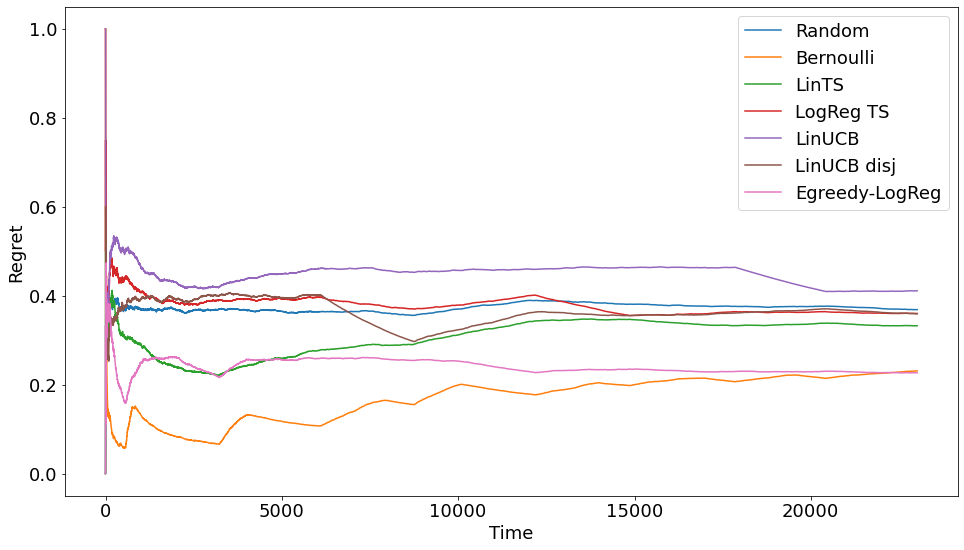

In [45]:
x = [i for i in range(T-1-starting_point)]
plt.plot(x, cum_reg_random, label="Random")
plt.plot(x, cum_reg_bernoulli, label="Bernoulli")
plt.plot(x, cum_reg_linear_ts, label="LinTS")
plt.plot(x, cum_reg_logreg_ts, label="LogReg TS")
plt.plot(x, cum_reg_LinUCB, label="LinUCB")
plt.plot(x, cum_reg_LinUCB_disjoint, label="LinUCB disj")
plt.plot(x, cum_reg_egreedy, label="Egreedy-LogReg")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Regret")
#plt.ylim(-0.05,1.05)
#plt.savefig(f"plots/T_{T}_onlyuser={only_user_context}.svg", facecolor="white", bordercolor="white")
plt.show()